In [ ]:
#coding=utf-8

"""
@author: evilXu
@file: testFactor.py
@time: 2017/11/16 17:48
@description: 
"""

from rqalpha.api import *
import traceback
from datetime import *
import pymysql
import pandas as pd
from rqalpha.utils.logger import user_log


def init(config):
    user_log.info("test Factor init")


def compute(startdt,enddt,config):
    '''
    PE
    :param startdt:
    :param enddt:
    :return:
    '''
    user_log.info("testFactor compute")
    _cnnConf = {"host":config.jydb,"port":3306,"db":"jydb","user":"liangh","passwd":"huaxun!@#db"}
    jyConn = pymysql.connect(host=_cnnConf.get("host"), port=_cnnConf.get("port") \
                                  , db=_cnnConf.get("db"), user=_cnnConf.get("user"),
                                  passwd=_cnnConf.get("passwd"), charset='utf8')
    _category = [1, ]
    _sectors = [1, 2, 6]
    _sql = "SELECT p.TradingDay,p.PE,a.SecuCode,a.SecuMarket" \
                   " FROM LC_DIndicesForValuation as p inner join secumain as a "\
                    "on a.innerCode=p.innerCode where a.SecuMarket in (83,90) " \
                   "and a.SecuCategory in (%s) and a.ListedSector in (%s) " \
                   "and a.ListedState!=9 and p.TradingDay between '%s' and '%s'" % (
                        ",".join([str(i) for i in _category]), ",".join([str(i) for i in _sectors])
                        ,startdt.strftime('%Y-%m-%d'),
                       enddt.strftime('%Y-%m-%d'))

    # print(_sql)
    _res = []
    _res_tmp = []
    try:
        _now = datetime.now()
        _cursor = jyConn.cursor()
        _cursor.execute(_sql)
        for _row in _cursor:
            _res_tmp.append({
                "code": _row[2] + "." + market(_row[3]),  # secumain.code(_row[0],_row[13]),#
                "date": _row[0],
                "value": float(_row[1])
            })
    except Exception as e:
        traceback.print_exc()
        return

    _res_tmp = sorted(_res_tmp,key=lambda x:x['date'])
    _res = []
    if len(_res_tmp) >0:
        _lastDt = _res_tmp[0]['date']
        _adt = {"date":_lastDt}
        for item in _res_tmp:
            if item['date'] != _lastDt:
                _res.append(_adt)
                _lastDt = item['date']
                _adt = {"date": _lastDt}
            else:
                _adt.update({item['code']:item['value']})
        if len(_adt) > 1:
            _res.append(_adt)
    if len(_res) < 1:
        return pd.DataFrame()
    return pd.DataFrame(_res).set_index(['date'])
    # print("testFactor")
                        
def market(market=90):
    if market == 83:
        return 'XSHG'
    elif market == 90:
        return 'XSHE'
    else:
        return ""

if __name__ == "__main__":
    from rqalpha.utils import RqAttrDict
    config= {"jydb":"172.18.44.5"}
    conf = RqAttrDict(config)
    fValue = compute(datetime(2015,6,8),datetime(2015,7,1).date(),fValue)
    # _fValue_aDay = fValue.iloc[0]
    print(fValue)
    print(fValue.index)

In [ ]:
# evaluateFileDemo
from rqalpha.mod.rqalpha_mod_alphaStar_factors import evaluate_file

config = {
  "base": {
    "start_date": "2017-06-01",
    "end_date": "2017-7-01",
  },
}

factor_file_path = "./testFactor.ipynb"

evaluate_file(factor_file_path=factor_file_path,config=config,config_file = "../config_factor.yml")

         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!
[2018-03-06 13:30:33.757451] DEBUG: system_log: evaluateRun
2017-06-01 INFO test Factor init
2017-06-01 INFO testFactor compute


2017-01-03 INFO test Factor init
2017-01-03 INFO testFactor compute
[2018-02-07 18:00:01.171061] INFO: system_log: get factor value success


没有 002926.XSHE 相关数据


[2018-02-07 18:00:53.747568] INFO: system_log: 2017-01-03 00:00:00, factorValue len:3088, yieldData len:3554
[2018-02-07 18:00:53.815246] INFO: system_log: 2017-01-10 00:00:00, factorValue len:3088, yieldData len:3554
[2018-02-07 18:00:53.877411] INFO: system_log: 2017-01-17 00:00:00, factorValue len:3088, yieldData len:3554


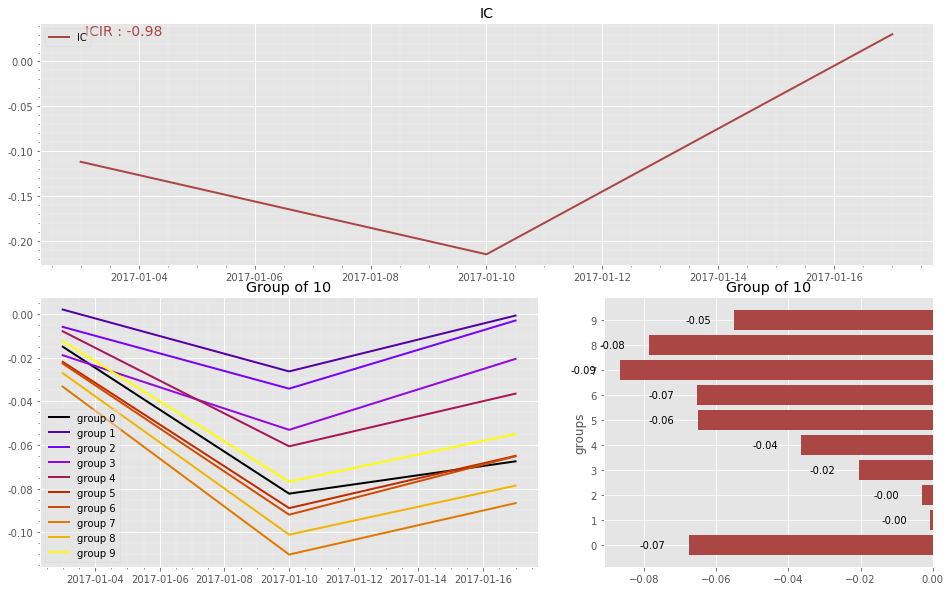

In [2]:
%load_ext rqalpha.mod.rqalpha_mod_alphaStar_factors
%evaluate -s 20170101 -e 20170131 -f ./testFactor.ipynb -rt r --config ../config_factor.yml